In [3]:
import jupyter_black

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader

from PIL import Image

import sys

if not "/usr/src" in sys.path:
    sys.path.append("/usr/src/")

jupyter_black.load()

In [6]:
# Custom modules
from dataset import create_substrate_dataset, get_part_substrates_from_all
from unet import UNet
from diffusion import Diffusion

In [4]:
# Dirs
substrate_dir = "/usr/src/substrates"
part_substrate_dir = "/usr/src/part_substrates"

In [ ]:
# Cut part_substrates
image_size = 256
get_part_substrates_from_all(
    substrate_dir, part_substrate_dir, part_size=(image_size, image_size)
)

In [7]:
substrate_dataset = create_substrate_dataset(part_substrate_dir)

channels = 1
batch_size = 30

train_loader = DataLoader(substrate_dataset, batch_size=batch_size, shuffle=True)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(img_dim=image_size, img_channels=channels)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [9]:
timesteps = 300
diffusion = Diffusion(timesteps)

In [10]:
epochs = 6
log_interval = len(train_loader) // 4

for epoch in range(epochs):
    print(f"----- Epoch {epoch + 1} -----")
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()

        batch_size = batch.shape[0]
        batch = batch.to(device)

        # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = diffusion.p_losses(model, batch, t, loss_type="huber")

        if step % log_interval == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

----- Epoch 1 -----
Loss: 0.4779285490512848
Loss: 0.021246496587991714
Loss: 0.00875165592879057
Loss: 0.010065947659313679
----- Epoch 2 -----
Loss: 0.002650751266628504
Loss: 0.00883864238858223
Loss: 0.004903986118733883
Loss: 0.0226664450019598
----- Epoch 3 -----
Loss: 0.005155368708074093
Loss: 0.003543449565768242
Loss: 0.009850593283772469
Loss: 0.012212690897285938
----- Epoch 4 -----
Loss: 0.004682139027863741
Loss: 0.01905321702361107
Loss: 0.012613169848918915
Loss: 0.0035763236228376627
----- Epoch 5 -----
Loss: 0.003569596214219928
Loss: 0.015879234299063683
Loss: 0.002064591972157359
Loss: 0.0020944129209965467
----- Epoch 6 -----
Loss: 0.026897907257080078
Loss: 0.005771894007921219
Loss: 0.0023427566047757864
Loss: 0.009190657176077366


sampling loop time step:   0%|          | 0/300 [00:00<?, ?it/s]

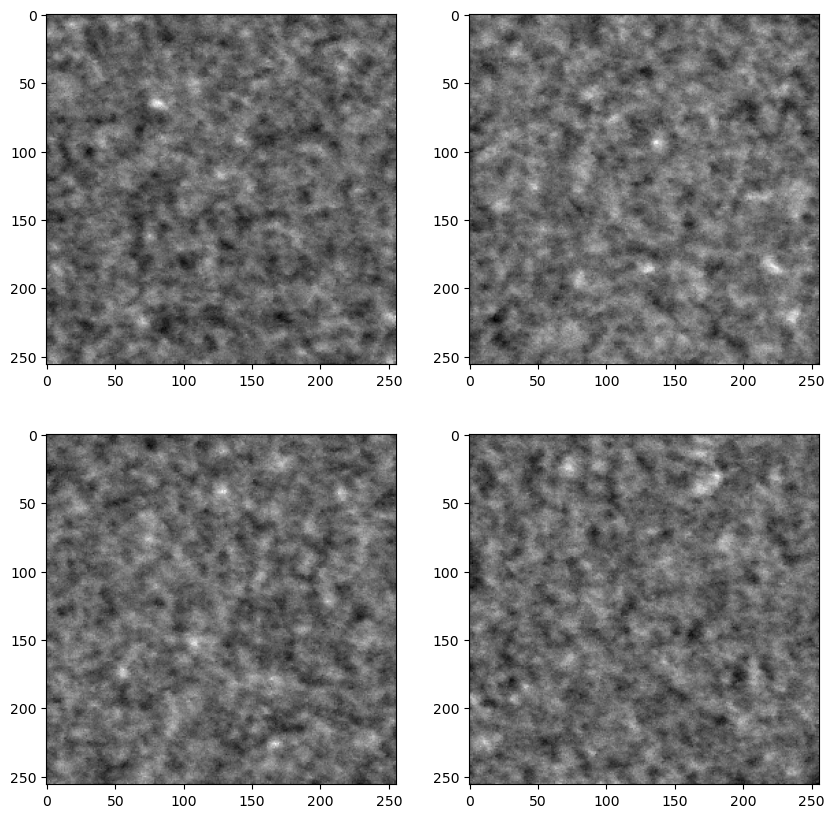

In [12]:
# sample 16 images
samples = diffusion.sample(
    model, image_size=image_size, batch_size=4, channels=channels
)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, img in zip(axes.flat, samples[-1]):
    ax.imshow(img.reshape(image_size, image_size, channels), cmap="gray")

In [ ]:
fig.savefig('4_samples_256_with_attention.png')

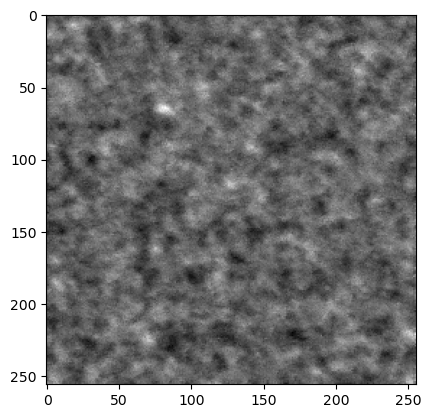

In [13]:
# show a random one
random_index = 0

plt.imshow(
    samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray"
)

In [ ]:
for idx, img in enumerate(samples[-1]):
    plt.imsave(f'sample_{idx}.png', img.reshape(image_size, image_size), cmap='gray')

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()